In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import scipy.linalg
import scipy.spatial.distance

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
DO_WHITENING = False
DO_CORAL = False
REG_PARAM = 1.0

# READ METADATA OF IMAGES (LEVEL 1)

In [3]:
featdir = "../features_res4a_relu_100/"
meta = pd.read_csv("../../inputs/metadata/index.csv", index_col=0)

In [4]:
moa_information = pd.read_csv("moa_information.csv", index_col=0)
meta['compound'], meta['concentration'] = meta["Compound_Concentration"].str.split("_", 1).str
meta = meta.join(moa_information.set_index("compound"), on="compound").reset_index()

# LOAD SINGLE CELL FEATURES (LEVEL 2)

In [5]:
features = []
indexes = meta.index
for i in tqdm(indexes):
    filename = featdir + "{}_{}_{}.npz"
    filename = filename.format(meta.loc[i, "Metadata_Plate"], meta.loc[i, "Metadata_Well"], meta.loc[i, "Metadata_Site"])
#     with open(filename, "rb") as data:
#         info = np.load(data)
#         features.append(info["f"])
    features.append(filename)

100%|██████████| 2412/2412 [00:00<00:00, 41157.93it/s]


In [6]:
def load_feature(filename):
    with open(filename, "rb") as data:
        info = np.load(data)
        feature = info["f"]
        return feature.reshape((-1,256))

In [7]:
total_single_cells = 0

print("Total images",len(features))
with open(features[0], "rb") as data:
    info = np.load(data)
    feature = info["f"]
    print("Original shape", feature.shape)
print("Converted shape", load_feature(features[0]).shape)
# print("Total single cells:", total_single_cells)

Total images 2412
Original shape (118, 6, 6, 256)
Converted shape (4248, 256)


# AGGREGATE INTO SITE LEVEL DATA (LEVEL 3)

In [8]:
site_level_data = []
site_level_features = []
for plate in tqdm(meta["Metadata_Plate"].unique()):
    m1 = meta["Metadata_Plate"] == plate
    wells = meta[m1]["Metadata_Well"].unique()
    for well in wells:
        result = meta.query("Metadata_Plate == '{}' and Metadata_Well == '{}'".format(plate, well))
        for i in result.index:
            loaded_feature = load_feature(features[i])
            num_features = loaded_feature.shape[1]
            mean_profile = loaded_feature.mean(axis=0)
            compound = result["compound"].unique()
            concentration = result["concentration"].unique()
            replicate = result["Replicate"].unique()
            moa = result["moa"].unique()
            if len(compound) > 1 or len(concentration) > 1 or len(moa) > 1:
                print(compound, concentration, moa)
            site_level_data.append(
                {
                    "Plate": plate,
                    "Well": well,
                    "Compound": compound[0],
                    "Concentration": concentration[0],
                    "Replicate": replicate[0],
                    "MOA": moa[0]
                }
            )
            site_level_features.append(mean_profile)

100%|██████████| 55/55 [01:10<00:00,  1.02s/it]


In [9]:
columns1 = ["Plate", "Well", "Compound", "Concentration", "MOA", "Batch", "Replicate"]
columns2 = [i for i in range(num_features)]
sites1 = pd.DataFrame(columns=columns1, data=site_level_data)
sites1["Batch"] = sites1["Plate"].apply(lambda x: x.split("_")[0])
sites2 = pd.DataFrame(columns=columns2, data=site_level_features)
sites = pd.concat([sites1, sites2], axis=1)

In [10]:
site_level_features[0].shape

(256,)

# TYPICAL VARIATION NORMALIZATION

In [11]:
def whitening_transform(X, lambda_, rotate=True):
    C = (1/X.shape[0]) * np.dot(X.T, X)
    s, V = scipy.linalg.eigh(C)
    D = np.diag( 1. / np.sqrt(s + lambda_) )
    W = np.dot(V, D)
    if rotate:
        W = np.dot(W, V.T)
    return W

def whiten(X, mu, W):
    return np.dot( X - mu, W)

In [12]:
feature_ids = [i for i in range(num_features)]
    
if DO_WHITENING:
    # Compute center of data around controls
    controls = sites["Compound"] == "DMSO"
    mean_ctl = sites.loc[controls, feature_ids].mean()

    # Whitening transform on controls
    all_controls_matrix = sites.loc[controls, feature_ids] - mean_ctl
    W = whitening_transform(all_controls_matrix, REG_PARAM, rotate=False)
    sites[feature_ids] = whiten(sites[feature_ids], mean_ctl, W)


In [13]:
if DO_CORAL:
    # Compute target matrix
    CF = sites.loc[sites["Compound"] == "DMSO", feature_ids]
    C_target = (1/CF.shape[0]) * np.dot(CF.T, CF)
    print("Is the covariance close the the identity?", np.allclose(C_target, np.eye(C_target.shape[0])))

    I = REG_PARAM * np.eye(C_target.shape[0])
    C_target = np.real(scipy.linalg.sqrtm(C_target + I))
    
    print(np.sum(C_target))
    plt.plot(np.diag(C_target))
    #plt.imshow(C_target)

In [14]:
if DO_CORAL:
    aligned_feature_matrix = np.zeros_like(sites[feature_ids])
    plates = sites["Batch"].unique()
    for p in tqdm(plates):
        plate_data = sites[sites["Batch"] == p]
        plate_index = plate_data.index.tolist()
        is_control = plate_data.Compound == "DMSO"
        controls_index = plate_data[is_control].index

        controls_features = sites.iloc[controls_index][feature_ids]
        plate_features = sites.iloc[plate_index][feature_ids]
        
        C_source = (1/controls_features.shape[0]) * np.dot(controls_features.T, controls_features)
        print("Is the covariance close the the identity?", np.allclose(C_source, np.eye(C_source.shape[0])))
        C_source = scipy.linalg.inv( np.real( scipy.linalg.sqrtm(C_source + np.eye(C_source.shape[0])) ) )
        
        print(controls_features.shape, np.sum(C_source))
        plt.figure()
        plt.plot(np.diag(C_source))
        
        X = np.dot(np.dot(plate_features, C_source), C_target)
        aligned_feature_matrix[plate_index, :] = X
        
    sites[feature_ids] = aligned_feature_matrix

# AGGREGATE INTO WELL DATA (LEVEL 4)

In [15]:
# Prepare MOA class IDs
moas = sites["MOA"].unique()
moa_to_id = {moas[i]:i for i in range(len(moas))}
id_to_moas = {moa_to_id[i]:i for i in moa_to_id.keys()}

# Collapse well data
wells = sites.groupby(["Plate", "Well", "Compound", "Concentration", "MOA"]).mean().reset_index()
wells = wells[wells["Compound"] != "DMSO"]
wells = wells[wells["Compound"] != "taxol"]
wells["MOA_class"] = wells["MOA"].apply(lambda x: moa_to_id[x])

# AGGREGATE INTO TREATMENTS (LEVEL 5)

In [16]:
treatments = sites.groupby(["Compound", "Concentration", "MOA"]).median().reset_index()
treatments = treatments.drop("Replicate", axis=1)
treatments = treatments[treatments["Compound"] != "DMSO"]
treatments["MOA_class"] = treatments["MOA"].apply(lambda x: moa_to_id[x])

In [17]:
treatments["Batch"] = ""
for i in treatments.index:
    result = sites.query("Compound == '{}' and Concentration == '{}'".format(treatments.loc[i,"Compound"], treatments.loc[i,"Concentration"]))
    treatments.loc[i,"Batch"] = ",".join(result["Batch"].unique())

# MOA CLASSIFICATION

## TREATMENT LEVEL - NOT SAME COMPOUND MATCHING

In [18]:
def knn(X, Y, T):
    neigh = KNeighborsClassifier(n_neighbors=1, algorithm="brute", metric="cosine")
    neigh.fit(X, Y)
    prediction = neigh.predict(T)
    return prediction[0]

def nsc(treatments):
    treatments["nsc"] = 0
    correct, total = 0, 0
    for i in treatments.index:
        # Leave one compound out
        training_data = treatments[treatments["Compound"] != treatments.loc[i, "Compound"]]
        test_data = np.asarray(treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
            treatments.loc[i, "nsc"] = 1
        else:
            print(len(training_data), treatments.loc[i, "Compound"], treatments.loc[i, "Concentration"], treatments.loc[i, "MOA"], moas[prediction])
        total += 1
    print("NSC Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nsc(treatments)
#print(" >> WELL LEVEL")
#nsc(wells)

 >> TREATMENT LEVEL
89 ALLN 3.0 Protein degradation DNA damage
85 AZ-A 0.1 Aurora kinase inhibitors Microtubule destabilizers
85 AZ-A 0.3 Aurora kinase inhibitors Actin disruptors
85 AZ-A 1.0 Aurora kinase inhibitors Microtubule destabilizers
85 AZ-A 10.0 Aurora kinase inhibitors Actin disruptors
85 AZ-A 3.0 Aurora kinase inhibitors Actin disruptors
85 AZ-A 30.0 Aurora kinase inhibitors Microtubule destabilizers
88 AZ258 0.1 Aurora kinase inhibitors DNA damage
88 AZ258 0.3 Aurora kinase inhibitors DNA damage
88 AZ258 1.0 Aurora kinase inhibitors DNA damage
88 AZ841 0.1 Aurora kinase inhibitors DNA damage
88 AZ841 0.3 Aurora kinase inhibitors DNA damage
88 AZ841 1.0 Aurora kinase inhibitors DNA damage
89 MG-132 3.0 Protein degradation Cholesterol-lowering
90 colchicine 0.03 Microtubule destabilizers Aurora kinase inhibitors
90 cytochalasin D 0.3 Actin disruptors Protein degradation
90 lactacystin 10.0 Protein degradation DNA damage
89 latrunculin B 1.0 Actin disruptors Aurora kinase inh

In [19]:
def knn(X, Y, T):
    neigh = KNeighborsClassifier(n_neighbors=1, algorithm="brute", metric="cosine")
    neigh.fit(X, Y)
    prediction = neigh.predict(T)
    return prediction[0]

def nsc(treatments):
    treatments["nsc"] = 0
    correct, total = 0, 0
    for i in treatments.index:
        # Leave one compound out
        training_data = treatments[treatments["Compound"] != treatments.loc[i, "Compound"]]
        test_data = np.asarray(treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
            treatments.loc[i, "nsc"] = 1
        else:
            print(len(training_data), treatments.loc[i, "Compound"], treatments.loc[i, "Concentration"], treatments.loc[i, "MOA"], moas[prediction])
        total += 1
    print("NSC Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nsc(treatments)
#print(" >> WELL LEVEL")
#nsc(wells)

 >> TREATMENT LEVEL
89 ALLN 3.0 Protein degradation DNA damage
85 AZ-A 0.1 Aurora kinase inhibitors Microtubule destabilizers
85 AZ-A 0.3 Aurora kinase inhibitors Actin disruptors
85 AZ-A 1.0 Aurora kinase inhibitors Microtubule destabilizers
85 AZ-A 10.0 Aurora kinase inhibitors Actin disruptors
85 AZ-A 3.0 Aurora kinase inhibitors Actin disruptors
85 AZ-A 30.0 Aurora kinase inhibitors Microtubule destabilizers
88 AZ258 0.1 Aurora kinase inhibitors DNA damage
88 AZ258 0.3 Aurora kinase inhibitors DNA damage
88 AZ258 1.0 Aurora kinase inhibitors DNA damage
88 AZ841 0.1 Aurora kinase inhibitors DNA damage
88 AZ841 0.3 Aurora kinase inhibitors DNA damage
88 AZ841 1.0 Aurora kinase inhibitors DNA damage
89 MG-132 3.0 Protein degradation Cholesterol-lowering
90 colchicine 0.03 Microtubule destabilizers Aurora kinase inhibitors
90 cytochalasin D 0.3 Actin disruptors Protein degradation
90 lactacystin 10.0 Protein degradation DNA damage
89 latrunculin B 1.0 Actin disruptors Aurora kinase inh

## TREATMENT LEVEL - NOT SAME COMPOUND, NOT SAME BATCH

In [20]:
def nscb(treatments):
    treatments["nscb"] = 1
    # Cholesterol-lowering and Kinase inhibitors are only in one batch
    valid_treatments = treatments[~treatments["MOA"].isin(["Cholesterol-lowering","Kinase inhibitors", "ALLN"])]
    
    correct, total = 0, 0
    for i in valid_treatments.index:
        # Leave same compound and batch out
        mask1 = valid_treatments["Compound"] != valid_treatments.loc[i, "Compound"]
        mask2 = valid_treatments["Batch"] != valid_treatments.loc[i, "Batch"]
        training_data = valid_treatments[mask1 & mask2]
        test_data = np.asarray(valid_treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if valid_treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
        else:
            print(len(training_data), 
                  valid_treatments.loc[i, "Compound"], 
                  valid_treatments.loc[i, "Concentration"], 
                  valid_treatments.loc[i, "MOA"], 
                  moas[prediction])
            treatments.loc[i, "nscb"] = 0
        total += 1
    print("NSCB Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nscb(treatments)

 >> TREATMENT LEVEL
79 ALLN 3.0 Protein degradation DNA damage
66 AZ-A 0.1 Aurora kinase inhibitors DNA damage
66 AZ-A 0.3 Aurora kinase inhibitors DNA damage
66 AZ-A 1.0 Aurora kinase inhibitors DNA damage
66 AZ-A 10.0 Aurora kinase inhibitors DNA damage
66 AZ-A 3.0 Aurora kinase inhibitors DNA damage
66 AZ-A 30.0 Aurora kinase inhibitors DNA damage
79 MG-132 0.1 Protein degradation DNA damage
79 MG-132 3.0 Protein degradation Protein synthesis
66 colchicine 0.03 Microtubule destabilizers DNA damage
66 cytochalasin B 10.0 Actin disruptors Protein synthesis
66 cytochalasin B 30.0 Actin disruptors Protein synthesis
79 cytochalasin D 0.3 Actin disruptors Protein synthesis
66 epothilone B 0.1 Microtubule stabilizers Eg5 inhibitors
66 epothilone B 0.3 Microtubule stabilizers Eg5 inhibitors
66 epothilone B 1.0 Microtubule stabilizers Eg5 inhibitors
84 lactacystin 10.0 Protein degradation DNA damage
66 latrunculin B 1.0 Actin disruptors Epithelial
66 latrunculin B 3.0 Actin disruptors Eg5 in

In [21]:
def nscb(treatments):
    treatments["nscb"] = 1
    # Cholesterol-lowering and Kinase inhibitors are only in one batch
    valid_treatments = treatments[~treatments["MOA"].isin(["Cholesterol-lowering","Kinase inhibitors", "ALLN"])]
    
    correct, total = 0, 0
    for i in valid_treatments.index:
        # Leave same compound and batch out
        mask1 = valid_treatments["Compound"] != valid_treatments.loc[i, "Compound"]
        mask2 = valid_treatments["Batch"] != valid_treatments.loc[i, "Batch"]
        training_data = valid_treatments[mask1 & mask2]
        test_data = np.asarray(valid_treatments.loc[i, feature_ids]).reshape(1, -1)
        prediction = knn(training_data[feature_ids], training_data["MOA_class"], test_data)
        # Check prediction
        if valid_treatments.loc[i, "MOA_class"] == prediction:
            correct += 1
        else:
            print(len(training_data), 
                  valid_treatments.loc[i, "Compound"], 
                  valid_treatments.loc[i, "Concentration"], 
                  valid_treatments.loc[i, "MOA"], 
                  moas[prediction])
            treatments.loc[i, "nscb"] = 0
        total += 1
    print("NSCB Accuracy: {} correct out of {} = {}".format(correct, total, correct/total) )
    
print(" >> TREATMENT LEVEL")
nscb(treatments)

 >> TREATMENT LEVEL
79 ALLN 3.0 Protein degradation DNA damage
66 AZ-A 0.1 Aurora kinase inhibitors DNA damage
66 AZ-A 0.3 Aurora kinase inhibitors DNA damage
66 AZ-A 1.0 Aurora kinase inhibitors DNA damage
66 AZ-A 10.0 Aurora kinase inhibitors DNA damage
66 AZ-A 3.0 Aurora kinase inhibitors DNA damage
66 AZ-A 30.0 Aurora kinase inhibitors DNA damage
79 MG-132 0.1 Protein degradation DNA damage
79 MG-132 3.0 Protein degradation Protein synthesis
66 colchicine 0.03 Microtubule destabilizers DNA damage
66 cytochalasin B 10.0 Actin disruptors Protein synthesis
66 cytochalasin B 30.0 Actin disruptors Protein synthesis
79 cytochalasin D 0.3 Actin disruptors Protein synthesis
66 epothilone B 0.1 Microtubule stabilizers Eg5 inhibitors
66 epothilone B 0.3 Microtubule stabilizers Eg5 inhibitors
66 epothilone B 1.0 Microtubule stabilizers Eg5 inhibitors
84 lactacystin 10.0 Protein degradation DNA damage
66 latrunculin B 1.0 Actin disruptors Epithelial
66 latrunculin B 3.0 Actin disruptors Eg5 in

In [22]:
treatments

Compound Concentration                        MOA         0  \
0                   ALLN         100.0        Protein degradation  0.767374   
1                   ALLN           3.0        Protein degradation  0.747718   
2                   AZ-A           0.1   Aurora kinase inhibitors  0.719534   
3                   AZ-A           0.3   Aurora kinase inhibitors  0.613146   
4                   AZ-A           1.0   Aurora kinase inhibitors  0.631713   
5                   AZ-A          10.0   Aurora kinase inhibitors  0.595387   
6                   AZ-A           3.0   Aurora kinase inhibitors  0.589023   
7                   AZ-A          30.0   Aurora kinase inhibitors  0.463549   
8                   AZ-C         0.001             Eg5 inhibitors  0.947820   
9                   AZ-C         0.003             Eg5 inhibitors  0.819263   
10                  AZ-C          0.01             Eg5 inhibitors  0.836004   
11                  AZ-C          0.03             Eg5 inhibitors  0.978408   
12                  AZ-C           0.1             Eg5 inhibitors  0.724719   
13                  AZ-C           0.3             Eg5 inhibitors  0.929635   
14                  AZ-C           1.0             Eg5 inhibitors  1.094063   
15                  AZ-J           1.0                 Epithelial  0.878839   
16                  AZ-J          10.0                 Epithelial  1.135918   
17                  AZ-J           3.0                 Epithelial  1.125421   
18                  AZ-U           1.0                 Epithelial  0.991412   
19                  AZ-U          10.0                 Epithelial  1.147008   
20                  AZ-U           3.0                 Epithelial  1.082417   
21                 AZ138          0.03             Eg5 inhibitors  1.072650   
22                 AZ138           0.1             Eg5 inhibitors  0.999173   
23                 AZ138           0.3             Eg5 inhibitors  1.052612   
24                 AZ138           1.0             Eg5 inhibitors  1.135398   
25                 AZ138           3.0             Eg5 inhibitors  1.303241   
26                 AZ258           0.1   Aurora kinase inhibitors  0.293499   
27                 AZ258           0.3   Aurora kinase inhibitors  0.284734   
28                 AZ258           1.0   Aurora kinase inhibitors  0.316475   
29                 AZ841           0.1   Aurora kinase inhibitors  0.411707   
..                   ...           ...                        ...       ...   
62           floxuridine          10.0            DNA replication  1.098799   
63           floxuridine          30.0            DNA replication  0.959598   
64           lactacystin          10.0        Protein degradation  0.983396   
65         latrunculin B           1.0           Actin disruptors  0.735888   
66         latrunculin B           3.0           Actin disruptors  0.750903   
67          methotrexate          10.0            DNA replication  0.733604   
68  mevinolin/lovastatin           1.5       Cholesterol-lowering  1.277382   
69  mevinolin/lovastatin          15.0       Cholesterol-lowering  1.545158   
70  mevinolin/lovastatin           5.0       Cholesterol-lowering  1.421729   
71           mitomycin C           0.1                 DNA damage  0.485245   
72           mitomycin C           0.3                 DNA damage  0.375349   
73           mitomycin C           1.0                 DNA damage  0.452048   
74           mitomycin C           3.0                 DNA damage  0.484703   
75          mitoxantrone         0.003            DNA replication  1.233154   
76          mitoxantrone          0.01            DNA replication  1.113857   
77            nocodazole           1.0  Microtubule destabilizers  0.902562   
78            nocodazole           3.0  Microtubule destabilizers  1.009713   
79           simvastatin           2.0       Cholesterol-lowering  1.271895   
80           simvastatin          20.0       Cholesterol-lowering 

# VISUALIZATION OF PROFILES

In [47]:
treated_wells = wells[~wells["Compound"].isin(["DMSO"])]#, "taxol"])]
treated_wells["nsc"] = -1
treated_wells["level"] = "wells"
treatments["level"] = "treatments"
embeddings = np.concatenate( [treated_wells[feature_ids], treatments[feature_ids]] )
C = scipy.spatial.distance.cdist(embeddings, embeddings, 'cosine')
tsne = TSNE()
projection = tsne.fit_transform(C)

In [76]:
df = pd.DataFrame(dict(
    x=projection[:,0],
    y=projection[:,1],
    moa=pd.concat([treated_wells["MOA"], treatments["MOA"]]),
    batch=pd.concat([treated_wells["Plate"].apply(lambda x: x.split("_")[0]), treatments["Batch"]]),
    compound=pd.concat([treated_wells["Compound"], treatments["Compound"]]),
    NSC_correct=pd.concat([treated_wells["nsc"],treatments["nsc"]]),
    NSCB_correct=pd.concat([treated_wells["nsc"],treatments["nscb"]]),
    level=pd.concat([treated_wells["level"],treatments["level"]])
))

In [77]:
df = df[(df.level == "treatments")&(df.batch == "Week3")]

<Figure size 432x288 with 0 Axes>

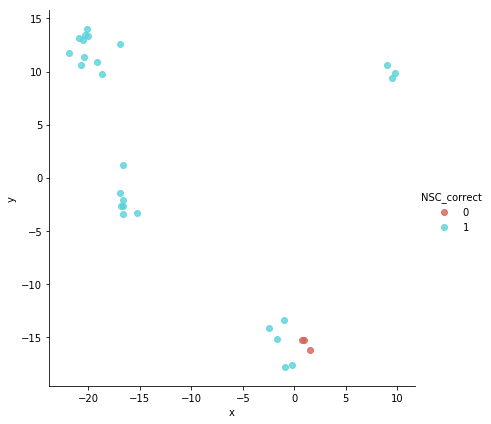

<Figure size 432x288 with 0 Axes>

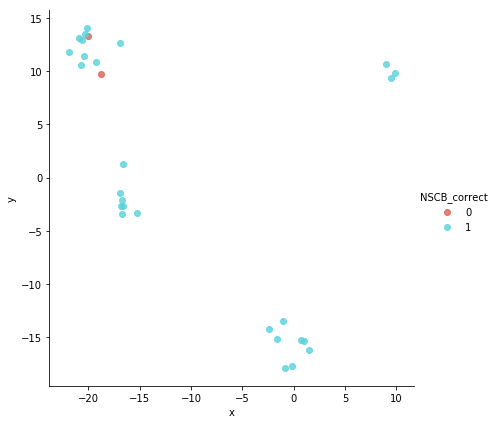

<Figure size 432x288 with 0 Axes>

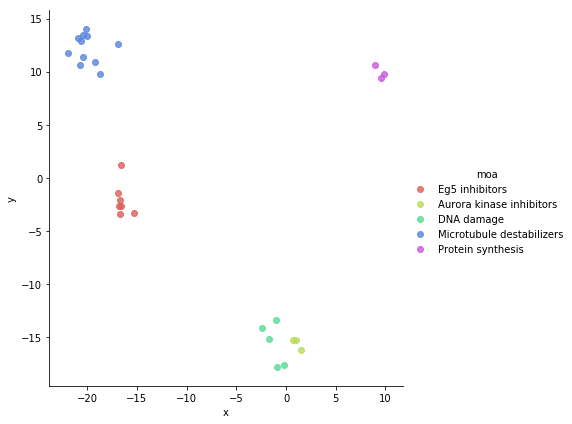

<Figure size 432x288 with 0 Axes>

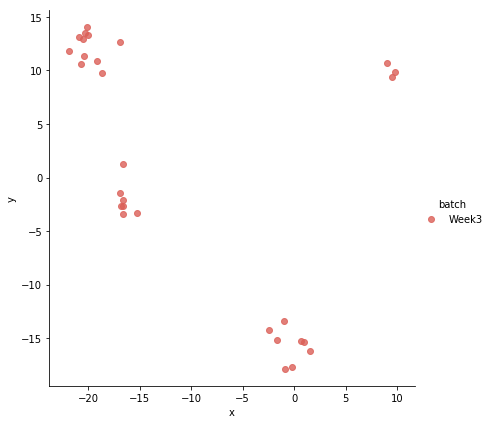

<Figure size 432x288 with 0 Axes>

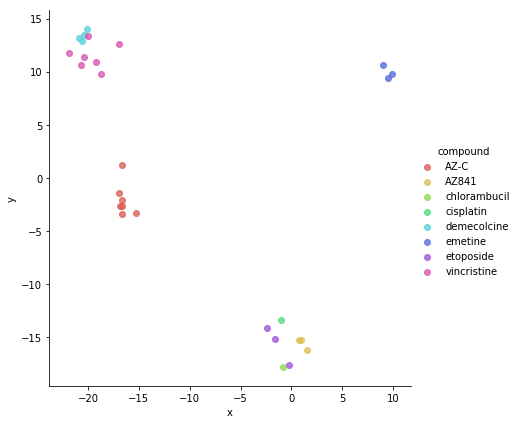

In [78]:
plt.figure()
sb.lmplot('x', 'y', data=df, hue='NSC_correct', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='NSCB_correct', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='moa', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='batch', fit_reg=False, palette="hls", size=6)

plt.figure()
sb.lmplot('x', 'y', data=df, hue='compound', fit_reg=False, palette="hls", size=6)